In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable

import torchvision.transforms as transforms
import torchvision.models as models

import glob
from PIL import Image
from skimage import color
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom

from colormath.color_objects import AdobeRGBColor, sRGBColor, LabColor
from colormath.color_conversions import convert_color

%matplotlib inline

In [2]:
image_list = glob.glob('data/ILSVRC2014_DET_train/ILSVRC2014_train_0000/*')
image_list = image_list[:10]

In [3]:
gray_images = ['data/ILSVRC2014_DET_train/ILSVRC2014_train_0000/ILSVRC2014_train_00008823.JPEG',
          'data/ILSVRC2014_DET_train/ILSVRC2014_train_0000/ILSVRC2014_train_00000278.JPEG',
          'data/ILSVRC2014_DET_train/ILSVRC2014_train_0000/ILSVRC2014_train_00008774.JPEG',
          'data/ILSVRC2014_DET_train/ILSVRC2014_train_0000/ILSVRC2014_train_00002194.JPEG',
          'data/ILSVRC2014_DET_train/ILSVRC2014_train_0000/ILSVRC2014_train_00004122.JPEG',
          'data/ILSVRC2014_DET_train/ILSVRC2014_train_0000/ILSVRC2014_train_00001535.JPEG']

for img in gray_images:
    if img in image_list:
        image_list.remove(img)

In [4]:
image = Image.open(random.choice(image_list))
image = image.resize((256, 256))

In [5]:
image_rgb = np.array(image)
image_lab = color.rgb2lab(image_rgb)
image_lab = image_lab.transpose(2, 0, 1)

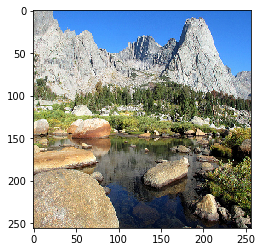

In [6]:
plt.imshow(color.lab2rgb(image_lab.transpose(1, 2, 0).astype(np.float64)))

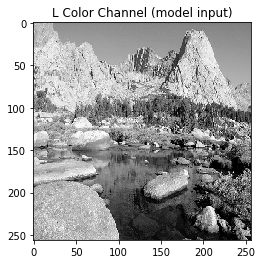

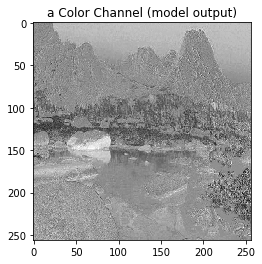

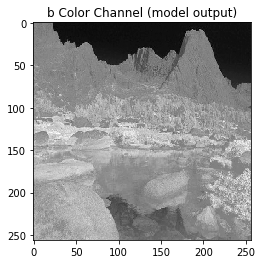

In [7]:
plt.figure()
plt.title('L Color Channel (model input)')
plt.imshow(image_lab[0, :, :], cmap='gray')

plt.figure()
plt.title('a Color Channel (model output)')
plt.imshow(image_lab[1, :, :], cmap='gray')

plt.figure()
plt.title('b Color Channel (model output)')
plt.imshow(image_lab[2, :, :], cmap='gray')

In [69]:
def quantize():
    groups = {}
    L = 50
    counter = 0
    for a in range(-120, 128, 10):
        for b in range(-120, 128, 10):
            lab = LabColor(L, a, b)
            rgb = convert_color(lab, sRGBColor)
            if rgb.rgb_r >= 0 and rgb.rgb_r <= 1 and rgb.rgb_b >= 0 and rgb.rgb_b <= 1 and rgb.rgb_g >= 0 and rgb.rgb_g <= 1:
                groups[(a, b)] = counter
                counter += 1
    return groups

In [70]:
ab2cat = quantize()
cat2ab = {v: k for k, v in ab2cat.items()}

In [71]:
class ColorizationDataset(data.Dataset):
    def __init__(self, img_names, image_size_in=256, image_size_out=64, classification=True):
        super(ColorizationDataset, self).__init__()
        self.image_size_in = image_size_in
        self.image_size_out = image_size_out
        self.img_names = img_names
        self.classification = classification
    
    def __getitem__(self, index):
        image = Image.open(self.img_names[index])
        image = image.resize((self.image_size_in, self.image_size_in))
        image_rgb = np.array(image)
        image_lab = color.rgb2lab(image_rgb)
        image_lab = image_lab.transpose(2, 0, 1)
        
        input, label = image_lab[0, :, :] - 50, image_lab[1:, :, :]
        label = zoom(label, (1, self.image_size_out / self.image_size_in, self.image_size_out / self.image_size_in))
        
        if self.classification:
            quantized_label = np.zeros((self.image_size_out, self.image_size_out)).astype(int)
            for i in range(self.image_size_out):
                for j in range(self.image_size_out):
                    a, b = label[0, i, j], label[1, i, j]
                    a, b = round(a / 10) * 10, round(b / 15) * 10
                    quantized_label[i, j] = ab2cat[(a, b)]

        return torch.FloatTensor(input).unsqueeze(0), torch.LongTensor(quantized_label)
    
    def __len__(self):
        return len(self.img_names)

In [72]:
dset = ColorizationDataset(image_list)
loader = data.DataLoader(dset, shuffle=True, batch_size=4)

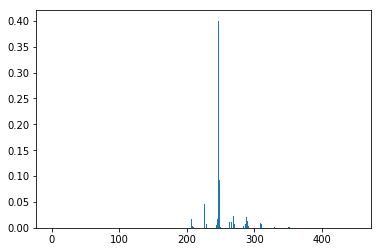

In [79]:
distribution = np.zeros(len(ab2cat))
for i in range(len(dset)):
    img, label = dset[i]
    count = np.bincount(label.numpy().reshape(-1))
    for val, freq in enumerate(count):
        distribution[val] += freq

distribution /= np.sum(distribution)
total = sum(distribution)

plt.bar(np.arange(len(ab2cat)), distribution)
plt.show()

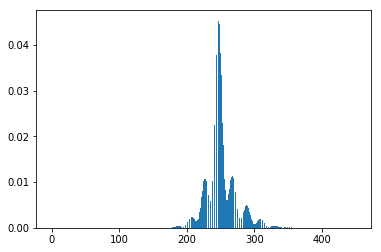

In [82]:
sigma = 5
x_vals = np.arange(len(ab2cat))
smoothed_dist = np.zeros(len(ab2cat))
for i in range(len(distribution)):
    kernel = np.exp(-(x_vals - i) ** 2 / (2 * sigma ** 2))
    kernel /= np.sum(kernel)
    smoothed_dist[i] = np.sum(kernel * distribution)

plt.bar(np.arange(len(ab2cat)), smoothed_dist)
plt.show()

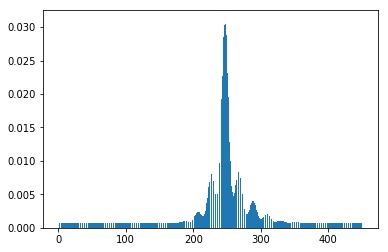

In [83]:
L = 0.5
smoothed_dist += L / len(ab2cat)
smoothed_dist /= np.sum(smoothed_dist)
plt.bar(np.arange(len(ab2cat)), smoothed_dist)
plt.show()

In [87]:
class ImageColorizer(nn.Module):
    def __init__(self, temperature=0.38, n_classes=451):
        super(ImageColorizer, self).__init__()
        self.n_classes = n_classes
        
        self.moduleList = nn.ModuleList()
        self.moduleList.append(self.conv_block(1, 64, 2, downsample=True))
        self.moduleList.append(self.conv_block(64, 128, 2, downsample=True))
        self.moduleList.append(self.conv_block(128, 256, 3, downsample=True))
        self.moduleList.append(self.conv_block(256, 512, 3))
        self.moduleList.append(self.conv_block(512, 512, 3, dilation=2, padding=2))
        self.moduleList.append(self.conv_block(512, 512, 3, dilation=2, padding=2))
        self.moduleList.append(self.conv_block(512, 512, 3))
        self.moduleList.append(self.deconv_block())
                         
        self.conv_class = nn.Conv2d(256, n_classes, 1)
        self.temperature = temperature
        
    def conv_block(self, in_dim, out_dim, n_convs, dilation=1, padding=1, downsample=False):
        block = []
        for i in range(0, n_convs):
            if i == 0:
                in_feat, stride = in_dim, 1
            elif i == n_convs - 1:
                in_feat, stride = out_dim, 2 if downsample else 1
            else:
                in_feat, stride = out_dim, 1
                
            block.append(nn.Conv2d(in_feat, out_dim, 3, padding=padding, stride=stride, dilation=dilation))
            block.append(nn.ReLU(inplace=True))

        block.append(nn.BatchNorm2d(out_dim))
        return nn.Sequential(*block)
    
    def deconv_block(self):
        block = []
        block.append(nn.ConvTranspose2d(512, 256, 4, padding=1, stride=2))
        block.append(nn.ReLU(inplace=True))
        block.append(nn.Conv2d(256, 256, 3, padding=1))
        block.append(nn.ReLU(inplace=True))
        block.append(nn.Conv2d(256, 256, 3, padding=1))
        block.append(nn.ReLU(inplace=True))
        return nn.Sequential(*block)
    
    def forward(self, input):
        for m in self.moduleList:
            input = m(input)

        input = self.conv_class(input)
        input *= 1 / self.temperature        
        return input

In [105]:
def train_model(model, optimizer, criterion, num_epochs=10, show_every=20):
    for epoch in range(num_epochs):
        print('Epoch %s' % epoch)
        print('=' * 10)
        
        running_loss = []
        for i, data in enumerate(iter(loader)):
            input, labels = data
            input, labels = Variable(input), Variable(labels)
            output = model(input)
                        
            optimizer.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            
            optimizer.step()
            
            running_loss.append(loss.data[0])
            if show_every is not None and i % show_every == 0:
                print('Iter %s: %s' % (i, np.mean(running_loss)))
        print('Average loss: %s' % (np.mean(running_loss)))
    
    return model

In [102]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal(m.weight.data)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [107]:
model = ImageColorizer(n_classes=len(ab2cat))
model.apply(weights_init)
optimizer = optim.RMSprop(model.parameters())

weights = torch.FloatTensor(1 / smoothed_dist)
nllCriterion = nn.NLLLoss2d(weight=weights)
criterion = lambda input, target: nllCriterion(F.log_softmax(input), target)

In [108]:
model = train_model(model, optimizer, criterion, num_epochs=50, show_every=None)

Epoch 0
Average loss: 255621.362081
Epoch 1
Average loss: 4.91309611003
Epoch 2
Average loss: 4.08541576068
Epoch 3
Average loss: 3.91527072589
Epoch 4
Average loss: 3.72140955925
Epoch 5
Average loss: 3.65295680364
Epoch 6
Average loss: 3.59944732984
Epoch 7
Average loss: 3.63233828545
Epoch 8
Average loss: 3.59310420354
Epoch 9
Average loss: 3.52077190081
Epoch 10
Average loss: 3.47924757004
Epoch 11
Average loss: 3.47088170052
Epoch 12
Average loss: 3.55013338725
Epoch 13
Average loss: 3.50895373027
Epoch 14
Average loss: 3.54247800509
Epoch 15
Average loss: 3.50391316414
Epoch 16


KeyboardInterrupt: 

In [109]:
def predict(model):
    input, label = next(iter(loader))
    input, label = input[0], label[0]
    L = input.numpy() + 50
    input = Variable(input.unsqueeze(0))
    out = model(input).squeeze(0)
    _, out = torch.max(out, 0)
    out = out.data.numpy()
    out_actual = np.zeros((2,) + out.shape)
    for i in range(out_actual.shape[1]):
        for j in range(out_actual.shape[2]):
            a, b = cat2ab[out[i, j]]
            out_actual[:, i, j] = [a + 20, b + 20]
    
    out_actual = zoom(out_actual, (1, 4, 4))
    pred = np.concatenate((L, out_actual), axis=0).transpose(1, 2, 0).clip(-128, 128)
    pred = color.lab2rgb(pred.astype(np.float64))
    
    plt.figure()
    plt.title('Grayscale')
    plt.imshow(L.squeeze(0), cmap='gray')
    
    plt.figure()
    plt.title('Predicted')
    plt.imshow(pred)


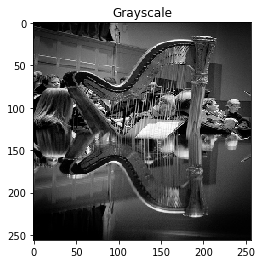

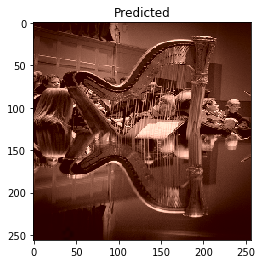

In [110]:
predict(model)